# Spatio-temporal Transcriptomics

Toy dataset from López-Lopera et al. (2019)

- Data download: https://github.com/anfelopera/PhysicallyGPDrosophila

In [1]:
import numpy as np
import torch

from torch.nn import Parameter
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
from scipy.interpolate import interp1d

from torch.optim import Adam
from gpytorch.optim import NGD

from lafomo.models import MultiOutputGP, PartialLFM, generate_multioutput_rbf_gp
from lafomo.models.pdes import ReactionDiffusion
from lafomo.utilities.data import dros_ground_truth
from lafomo.utilities.fenics import interval_mesh
from lafomo.datasets import DrosophilaSpatialTranscriptomics, HomogeneousReactionDiffusion
from lafomo.trainers import PartialPreEstimator, PDETrainer
from lafomo.plot import plot_spatiotemporal_data
from lafomo.utilities.torch import softplus, inv_softplus

from lafomo.configuration import VariationalConfiguration

In [56]:
drosophila = True
if drosophila:
    gene = 'kr'
    dataset = DrosophilaSpatialTranscriptomics(
        gene=gene, data_dir='../../../data', scale=True, disc=20)
    params = dict(lengthscale=10,
                  **dros_ground_truth(gene),
                  parameter_grad=False,
                  warm_epochs=-1,
                  natural=True,
                  zero_mean=True,
                  clamp=True)
    disc = dataset.disc
else:
    data = 'toy-spatial'
    dataset = HomogeneousReactionDiffusion(data_dir='../../../data')
    params = dict(lengthscale=0.2,
                  sensitivity=1,
                  decay=0.1,
                  diffusion=0.01,
                  warm_epochs=-1,
                  dp=0.025,
                  natural=False,
                  clamp=False)
    disc = 1

data = next(iter(dataset))
tx, y_target = data
lengthscale = params['lengthscale']
zero_mean = params['zero_mean'] if 'zero_mean' in params else False

We can either create a simple unit interval mesh

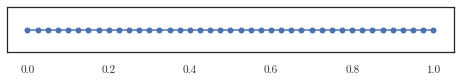

In [57]:
from dolfin import *
mesh = UnitIntervalMesh(40)
plot(mesh)

Alternatively, if our spatial data is not uniformly spaced, we can define a custom mesh as follows.

Matching: True


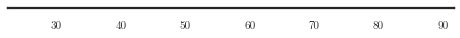

In [58]:
# We calculate a mesh that contains all possible spatial locations in the dataset

spatial = np.unique(tx[1, :])
mesh = interval_mesh(spatial)
plot(mesh)
# The mesh coordinates should match up to the data:
print('Matching:', (spatial == mesh.coordinates().reshape(-1)).all())

Set up GP model

tx torch.Size([2, 512])
torch.Size([1, 426, 2])


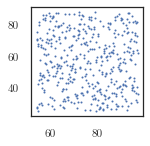

In [59]:
# Define GP
if tx.shape[1] > 1000:
    num_inducing = int(tx.shape[1] * 3/6)
else:
    num_inducing = int(tx.shape[1] * 5/6)
use_lhs = True
if use_lhs:
    print('tx', tx.shape)
    from smt.sampling_methods import LHS
    ts = tx[0, :].unique().sort()[0].numpy()
    xs = tx[1, :].unique().sort()[0].numpy()
    xlimits = np.array([[ts[0], ts[-1]],[xs[0], xs[-1]]])
    sampling = LHS(xlimits=xlimits)
    inducing_points = torch.tensor(sampling(num_inducing)).unsqueeze(0)
else:
    inducing_points = torch.stack([
        tx[0, torch.randperm(tx.shape[1])[:num_inducing]],
        tx[1, torch.randperm(tx.shape[1])[:num_inducing]]
    ], dim=1).unsqueeze(0)

gp_kwargs = dict(learn_inducing_locations=False,
                 natural=params['natural'],
                 use_tril=True)

gp_model = generate_multioutput_rbf_gp(
    1, inducing_points,
    initial_lengthscale=lengthscale,
    ard_dims=2,
    zero_mean=zero_mean,
    gp_kwargs=gp_kwargs)
gp_model.covar_module.lengthscale = lengthscale
# lengthscale_constraint=Interval(0.1, 0.3),
gp_model.double()

print(inducing_points.shape)
plt.figure(figsize=(2, 2))
plt.scatter(inducing_points[0,:,0], inducing_points[0, :, 1], s=1)

Set up PDE (fenics module)

In [60]:
# Define fenics model
ts = tx[0, :].unique().sort()[0].numpy()
t_range = (ts[0], ts[-1])
print(t_range)
time_steps = dataset.num_discretised
fenics_model = ReactionDiffusion(t_range, time_steps, mesh)

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=5
)


(53.925, 97.675)


In [61]:
# Define LFM
parameter_grad = params['parameter_grad'] if 'parameter_grad' in params else True
sensitivity = Parameter(
    inv_softplus(torch.tensor(params['sensitivity'])) * torch.ones((1, 1), dtype=torch.float64),
    requires_grad=False)
decay = Parameter(
    inv_softplus(torch.tensor(params['decay'])) * torch.ones((1, 1), dtype=torch.float64),
    requires_grad=parameter_grad)
diffusion = Parameter(
    inv_softplus(torch.tensor(params['diffusion'])) * torch.ones((1, 1), dtype=torch.float64),
    requires_grad=parameter_grad)

fenics_params = [sensitivity, decay, diffusion]

train_ratio = 0.3
num_training = int(train_ratio * tx.shape[1])

lfm = PartialLFM(1, gp_model, fenics_model, fenics_params, config, num_training_points=num_training)

In [62]:
if params['natural']:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.03)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.03)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.005)]

track_parameters = list(lfm.fenics_named_parameters.keys()) +\
                   list(map(lambda s: f'gp_model.{s}', dict(lfm.gp_model.named_hyperparameters()).keys()))

# As in Lopez-Lopera et al., we take 30% of data for training
train_mask = torch.zeros_like(tx[0, :])
train_mask[torch.randperm(tx.shape[1])[:int(train_ratio * tx.shape[1])]] = 1

orig_data = dataset.orig_data.squeeze().t()
trainer = PDETrainer(lfm, optimizers, dataset,
                     clamp=params['clamp'],
                     track_parameters=track_parameters,
                     train_mask=train_mask.bool(),
                     warm_variational=-1,
                     lf_target=orig_data)
tx = trainer.tx
num_t_orig = orig_data[:, 0].unique().shape[0]
num_x_orig = orig_data[:, 1].unique().shape[0]
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]

ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

x dp is set to tensor(1., dtype=torch.float64)


Now let's see some samples from the GP and corresponding LFM output


/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([53.9250, 54.2375, 54.5500, 54.8625, 55.1750, 55.4875, 55.8000, 56.1125,
        56.4250, 56.7375, 57.0500, 57.3625, 57.6750, 57.9875, 58.3000, 58.6125,
        58.9250, 59.2375, 59.5500, 59.8625, 60.1750, 60.4875, 60.8000, 61.1125,
        61.4250, 61.7375, 62.0500, 62.3625, 62.6750, 62.9875, 63.3000, 63.6125,
        63.9250, 64.2375, 64.5500, 64.8625, 65.1750, 65.4875, 65.8000, 66.1125,
        66.4250, 66.7375, 67.0500, 67.3625, 67.6750, 67.9875, 68.3000, 68.6125,
        68.9250, 69.2375, 69.5500, 69.8625, 70.1750, 70.4875, 70.8000, 71.1125,
        71.4250, 71.7375, 72.0500, 72.3625, 72.6750, 72.9875, 73.3000, 73.6125,
        73.9250, 74.2375, 74.5500, 74.8625, 75.1750, 75.4875, 75.8000, 76.1125,
        76.4250, 76.7375, 77.0500, 77.3625, 77.6750, 77.9875, 78.3000, 78.6125,
        78.9250, 79.2375, 79.5500, 79.8625, 80.1750, 80.4875, 80.8000, 81.1125,
        81.4250, 81.7375, 82.0500, 82.3625, 82.6750, 82.9875, 83.3000, 83.6125,
        83.9250, 84.2375, 84.5500, 84.86

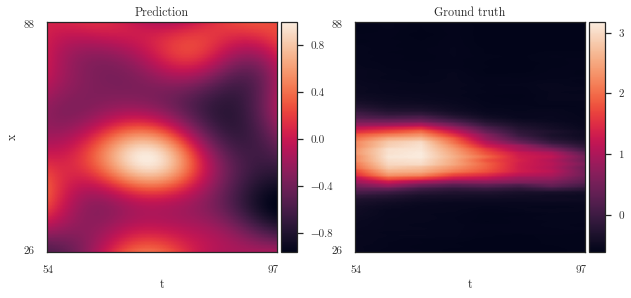

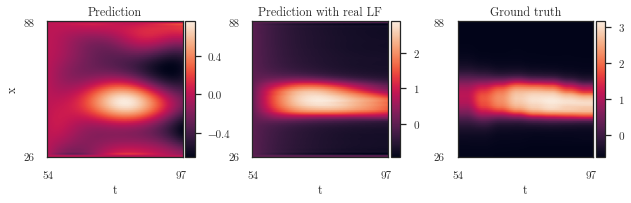

In [63]:
time = dataset.orig_data[0].unique()
latent = torch.tensor(orig_data[trainer.t_sorted, 2]).unsqueeze(0)
latent = latent.repeat(lfm.config.num_samples, 1, 1)
latent = latent.view(lfm.config.num_samples, 1, num_t_orig, num_x_orig)
time_interp = tx[0].unique()
print(time_interp, time)
time_interp[-1] -= 1e-5
print(time_interp)
latent = torch.from_numpy(interp1d(time, latent, axis=2)(time_interp))

# gp_model.covar_module.lengthscale = 0.3*0.3 * 2
out = gp_model(trainer.tx.transpose(0, 1))
sample = out.sample(torch.Size([lfm.config.num_samples])).permute(0, 2, 1)
plot_spatiotemporal_data(
    [
        sample.mean(0)[0].detach().view(num_t, num_x).t(),
        latent[0].squeeze().view(num_t, num_x).t(),
    ],
    extent,
    titles=['Prediction', 'Ground truth']
)
sample = sample.view(lfm.config.num_samples, 1, num_t, num_x)

output_pred = lfm.solve_pde(sample).mean(0)
output = lfm.solve_pde(latent).mean(0)
print(output.shape)
plot_spatiotemporal_data(
    [
        output_pred.squeeze().detach().t(),
        output.squeeze().detach().t(),
        trainer.y_target.view(num_t_orig, num_x_orig).t()
    ],
    extent,
    titles=['Prediction', 'Prediction with real LF', 'Ground truth']
)

In [ ]:

num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
y_target = trainer.y_target[0]
y_matrix = y_target.view(num_t_orig, num_x_orig)

pde_func, pde_target = lfm.fenics_model.interpolated_gradient(tx, y_matrix, disc=disc, plot=True)

u = orig_data[trainer.t_sorted, 2].view(num_t_orig, num_x_orig)
u = u.view(1, -1)
print(u.shape)
dy_t_ = pde_func(
    trainer.y_target,
    u.repeat(25, 1),
    sensitivity.unsqueeze(0).repeat(25, 1),
    decay.unsqueeze(0).repeat(25, 1),
    diffusion.unsqueeze(0).repeat(25, 1))[0]

plot_spatiotemporal_data([dy_t_.view(num_t, num_x).t()],
                         extent=extent, figsize=(3,3))

In [ ]:
train_ratio = 0.3
num_training = int(train_ratio * tx.shape[1])
print(num_training)
if params['natural']:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.05)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.09)]


pre_estimator = PartialPreEstimator(
    lfm, optimizers, dataset, pde_func,
    input_pair=(trainer.tx, trainer.y_target), target=pde_target,
    train_mask=trainer.train_mask
)

In [ ]:
import time
t0 = time.time()
lfm.pretrain(True)
lfm.config.num_samples = 50
times = pre_estimator.train(100, report_interval=5)
lfm.config.num_samples = 5

In [ ]:
from lafomo.utilities.torch import q2, cia
lfm.eval()
f = lfm(tx)
print(f.mean.shape)
f_mean = f.mean.detach()
f_var = f.variance.detach()
y_target = trainer.y_target[0]

print(f_mean.shape, y_target.shape, f_var.shape)
print('prot Q2', q2(y_target.squeeze(), f_mean.squeeze()))
print('prot CA', cia(y_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))
gp = lfm.gp_model(tx.t())
lf_target = orig_data[trainer.t_sorted, 2]
f_mean = gp.mean.detach().view(num_t, num_x)[::disc].reshape(-1)
f_var = gp.variance.detach().view(num_t, num_x)[::disc].reshape(-1)

print('mrna Q2', q2(lf_target.squeeze(), f_mean.squeeze()))
print('mrna CA', cia(lf_target.squeeze(), f_mean.squeeze(), f_var.squeeze()))


print(np.stack(times).shape)
plt.plot(np.stack(times)[:, 1])

In [ ]:
#print(hihi)

trainer.train(2)

In [24]:

lfm.config.num_samples = 5
lfm.eval()
u = lfm.gp_model(trainer.tx.t()).sample(torch.Size([5])).permute(0, 2, 1)
u = u.view(*u.shape[:2], num_t, num_x)
dy_t_ = pde_func(
    trainer.y_target,
    u[:, :, ::disc].contiguous(),
    sensitivity.unsqueeze(0).repeat(5, 1),
    decay.unsqueeze(0).repeat(5, 1),
    diffusion.unsqueeze(0).repeat(5, 1))[0]

out_predicted = lfm.solve_pde(u.view(5, 1, num_t, num_x)).mean(0)

ts = tx[0, :].unique().numpy()
xs = tx[1, :].unique().numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]
axes = plot_spatiotemporal_data(
    [
        trainer.y_target.view(num_t_orig, num_x_orig).t(),
        dy_t.reshape(num_t_orig, num_x_orig).t(),
        dy_t_.view(num_t_orig, num_x_orig).t(),
        latent[0].view(num_t, num_x).t(),
        u.mean(0).view(num_t, num_x).t(),
    ],
    extent, titles=['y', 'target dy_t', 'pred dy_t_', 'target latent', 'pred latent']
)
plot_spatiotemporal_data(
    [
        real.t().detach(),
        # trainer.y_target.view(num_t_orig, num_x_orig).t(),
        out_predicted.t().detach()
    ],
    extent, titles=['Target', 'Predicted']
)
print([softplus(param).item() for param in lfm.fenics_parameters])

torch.Size([25, 1, 512])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [25]:
lfm = PartialLFM.load(filepath,
                      gp_cls=MultiOutputGP,
                      gp_args=[inducing_points, 1],
                      gp_kwargs=gp_kwargs,
                      lfm_args=[1, fenics_model, fenics_params, config])
# lfm = PartialLFM(gp_model, fenics_model, fenics_params, config)

gp_model = lfm.gp_model
optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset, track_parameters=list(lfm.fenics_named_parameters.keys()))

t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
x dp is set to 1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


In [26]:
from lafomo.utilities.torch import smse, cia, q2

num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]
# f_mean = lfm(tx).mean.detach()
# f_var = lfm(tx).variance.detach()
y_target = trainer.y_target[0]
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
t_diff = ts[-1] - ts[0]
x_diff = xs[-1] - xs[0]
extent = [ts[0], ts[-1], xs[0], xs[-1]]
print(y_target.shape, f_mean.squeeze().shape)
f_mean_test = f_mean.squeeze()
f_var_test = f_var.squeeze()

print(q2(y_target, f_mean.squeeze()))
print(cia(y_target, f_mean_test, f_var_test).item())
print(smse(y_target, f_mean_test).mean().item())

NameError: name 'f_mean' is not defined

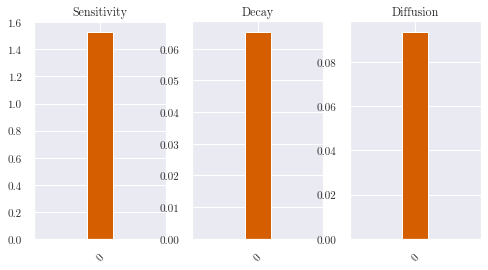

In [32]:
plotter = Plotter(lfm, np.arange(1))

labels = ['Sensitivity', 'Decay', 'Diffusion']
kinetics = list()
for key in lfm.fenics_named_parameters.keys():
    kinetics.append(softplus(trainer.parameter_trace[key][-1]).squeeze().numpy())

plotter.plot_double_bar(kinetics, labels)

# plotter.plot_latents()